# Model Analysis & Evaluation

In [ ]:
# Importing Libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Plot Customisation
%matplotlib inline
sns.set_theme(style = "whitegrid", palette = "pastel")

## Notebook Setup

In [1]:
# Defining file variables
file_path = '../data/analysis_data/eda_customer_churn.pkl'
result_path = '../results/'
result_name = 'model_comparison_result'
result_ext = '.csv'
results = {}

# Modelling Parameters
testing_size = 0.2

# Target column
target = 'Churn'

In [2]:
# Separating & Categorising Features
demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

service_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'TechSupport']

payment_features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']

categorical_features = list(set(service_features + payment_features) - set(binary_features))

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

## Notebook Functions

In [3]:
# Creating a loading and preprocessing function
def load_preprocess(filename, drop_aux, one_hot, encode_binary, encode_gender) -> pd.DataFrame:
    churn_df = pd.read_pickle('../data/analysis_data/eda_customer_churn.pkl')
    if drop_aux:
        # Dropping customerID
        churn_df = churn_df.drop(columns = ['customerID'])
    
    if one_hot:
        ohe = OneHotEncoder(categories = 'auto', sparse_output = False, handle_unknown = 'ignore')
        
        # Transforming & Fitting Categorical Columns
        categorical_features_encoded = ohe.fit_transform(churn_df[categorical_features])

        # Making the transformed data into a DataFrame
        column_names = ohe.get_feature_names_out(categorical_features)
        categorical_features_encoded = pd.DataFrame(data = categorical_features_encoded, columns = column_names, index = churn_df.index)

        # Dropping Categorical Features from Orignial DataFrame
        churn_df = churn_df.drop(columns = categorical_features)

        # Concatenating Encoded Columns
        churn_df = pd.concat([churn_df, categorical_features_encoded], axis = 1)

    if encode_binary:
        # Features for Mapping
        mapping_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

        # Mapping of `Yes` and `No` to `1` and `0`
        for col in mapping_features:
            churn_df[col] = churn_df[col].map({'Yes': 1, 'No': 0})
    
    if encode_gender:
        # Mapping 'Male'/'Female' to 1/0
        churn_df['gender'] = churn_df['gender'].map({'Male': 1, 'Female': 0})

    return churn_df

In [4]:
# Creating a model evaluation function
def evaluate_model(trained_models_object, train_set, test_set, train_target, test_target) -> dict:
    
    # Fitting the models
    trained_models_object.fit(train_set, train_target)
    
    # Predicting the models
    y_pred = trained_models_object.predict(test_set)
    
    # Get probabilities or decision function for ROC AUC
    if hasattr(trained_models_object, "predict_proba"):
        y_score = trained_models_object.predict_proba(test_set)[:, 1]
    elif hasattr(trained_models_object, "decision_function"):
        y_score = trained_models_object.decision_function(test_set)
    else:
        y_score = None
    
    # Storing away the results
    return {
        "accuracy": accuracy_score(test_target, y_pred),
        "precision": precision_score(test_target, y_pred),
        "recall": recall_score(test_target, y_pred),
        "f1_score": f1_score(test_target, y_pred),
        "roc_auc": (
            roc_auc_score(test_target, y_score) if y_score is not None else float("nan")
        ),
        "cm": confusion_matrix(test_target, y_pred),
        }

In [5]:
# Creating a ROC Plotting function
def plot_roc_curves(results_dict, title="ROC Curves"):
    """
    Plots ROC curves for multiple models based on the results dictionary.
    :param results_dict: Dictionary containing model names as keys and their evaluation results as values.
    :param title: Title for the plot.
    """

    # Ensuring that we have a results dictionary
    if not results_dict:
        raise ValueError(
            "The results dictionary is empty. Please provide valid model results."
        )

    # Creating the plots
    plt.figure(figsize=(8, 6))
    for n, m in results_dict.items():
        ypp = m["ypp"]
        y_test = m["y_test"]
        if ypp is None or y_test is None:
            raise ValueError(
                f"Model {n} does not have valid predictions or test labels."
            )
        if len(ypp) == 0 or len(y_test) == 0:
            raise ValueError(f"Model {n} has empty predictions or test labels.")
        fpr, tpr, _ = roc_curve(y_test, ypp)
        auc_score = roc_auc_score(y_test, ypp)
        plt.plot(fpr, tpr, label=f"{n} (AUC = {auc_score:.3f})")

    # Creating a linear plot
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

    # Customising the plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Analysis Start

In [6]:
# Loading and preprocessing the data
df = load_preprocess(filename = file_path,
                     drop_aux = True,
                     one_hot = True,
                     encode_binary = True,
                     encode_gender = True
                     )

# Preview
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,OnlineSecurity_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Defining the X and y
y = df['Churn']
X = df.drop(columns = ['Churn'], axis = 1)

# Performing the Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialising SMOTE
smote = SMOTE(random_state = 42)

# Performing SMOTE - Churn has an approximately 70:30
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### Handling Class Imbalance with SMOTE
In our dataset, the target variable `Churn` is imbalanced, with approximately **73% non-churn** and **27% churn** cases. This imbalance can lead to biased model performance, where classifiers favour the majority class (non-churn) which will cause a failure in to correctly classify minority class instances. Such a bias is especially problematic in churn prediction tasks, where identifying customers at risk of leaving is crucial for business action.

To resolve this, I used **SMOTE (Synthetic Minority Over-sampling Technique)** on the training data. SMOTE workds by creating *synthetic examples* of the minority class based on the feature space similarities between existing minority samples. 

I applied SMOTE to the **training dataset** only to avoid data leakage. 

In [8]:
# Creating our prediction models
models = {"Logistic Regression": LogisticRegression(max_iter = 10000, random_state = 42),
        "Random Forest": RandomForestClassifier(random_state = 42),
        "Support Vector Machine": SVC(kernel="rbf", probability = True, random_state = 42),
        "Gradient Boosting": GradientBoostingClassifier(random_state = 42),
        "AdaBoost": AdaBoostClassifier(random_state = 42),
        "Decision Tree": DecisionTreeClassifier(random_state = 42),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        }

In [9]:
# Setting parameters for the models
param_grids = {"Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10, 100]},
        "Random Forest": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
        "Support Vector Machine": {
            "C": [0.01, 0.1, 1, 10, 100],
            "gamma": ["scale", "auto"],
            "kernel": ["rbf"],
        },
        "Gradient Boosting": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
        },
        "AdaBoost": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
        },
        "Decision Tree": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
        "K-Nearest Neighbors": {
            "n_neighbors": [3, 5, 7, 9, 15],
            "weights": ["uniform", "distance"],
            "p": [1, 2],  # p=1 for Manhattan, p=2 for Euclidean
        },
        }

In [10]:
# Going through the models
results = {}
results_smote = {}
trained_models = {}
training_times = {}
overall_start = time.time()

# Looping through the models
for name, model in models.items():
    start_time = time.time()
    print(f"\nTraining {name}...")
    if name in param_grids:
        print(f"Performing GridSearchCV for {name}...")
        grid_search = GridSearchCV(
            model, param_grids[name], cv = 5, scoring = "roc_auc", n_jobs = -1
        )
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        best_model = model

    results[name] = evaluate_model(
        best_model, X_train_smote, X_test, y_train_smote, y_test
    )

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Execution time for {name}: {training_time:.2f} seconds")

    training_times[name] = training_time
    trained_models[name] = {}
    trained_models[name]["model"] = best_model

# Timing stats
overall_end = time.time()
total_training_time = overall_end - overall_start
print(f"\nTotal execution time for all models: {total_training_time:.2f} seconds")


Training Logistic Regression...
Performing GridSearchCV for Logistic Regression...
Best parameters for Logistic Regression: {'C': 100}
Execution time for Logistic Regression: 19.97 seconds

Training Random Forest...
Performing GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Execution time for Random Forest: 88.45 seconds

Training Support Vector Machine...
Performing GridSearchCV for Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Execution time for Support Vector Machine: 102.80 seconds

Training Gradient Boosting...
Performing GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Execution time for Gradient Boosting: 150.09 seconds

Training AdaBoost...
Performing GridSearchCV for AdaBoost...
Best parameters for 

In [12]:
# Adding ypp (predicted probabilities) and cm to trained_models, later used for ROC analysis
for n, m in trained_models.items():
    model = m["model"]
    if hasattr(model, "predict_proba"):
        ypp = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        ypp = model.decision_function(X_test)
    else:
        print(f"Model {n} does not support probability prediction. ignoring it.")
        continue
    
    trained_models[n]["ypp"] = ypp
    trained_models[n]["y_test"] = y_test
    trained_models[n]["X_test"] = X_test

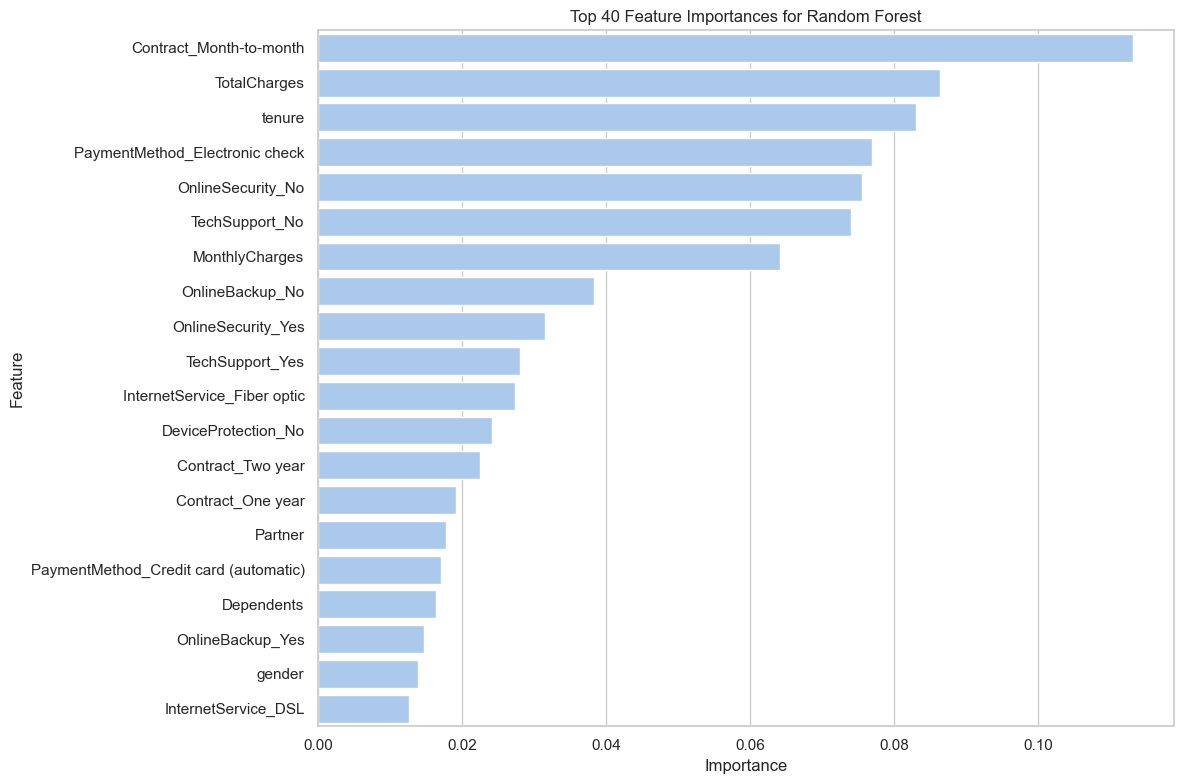

In [16]:
# Feature Importance for Random Forest
rf_model = trained_models['Random Forest']['model']
importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances}
).sort_values(by = 'Importance', ascending = False)

# Creating the figure
plt.figure(figsize = (12, 8))
sns.barplot(data = feat_importance_df.head(20), x = 'Importance', y = 'Feature')

# Customising the plot
plt.title(f"Top {len(feat_importance_df)} Feature Importances for Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()

# Showing the plot
plt.show();

### Analysing Model Performance
#### Performance Comparisons

<Figure size 1200x600 with 0 Axes>

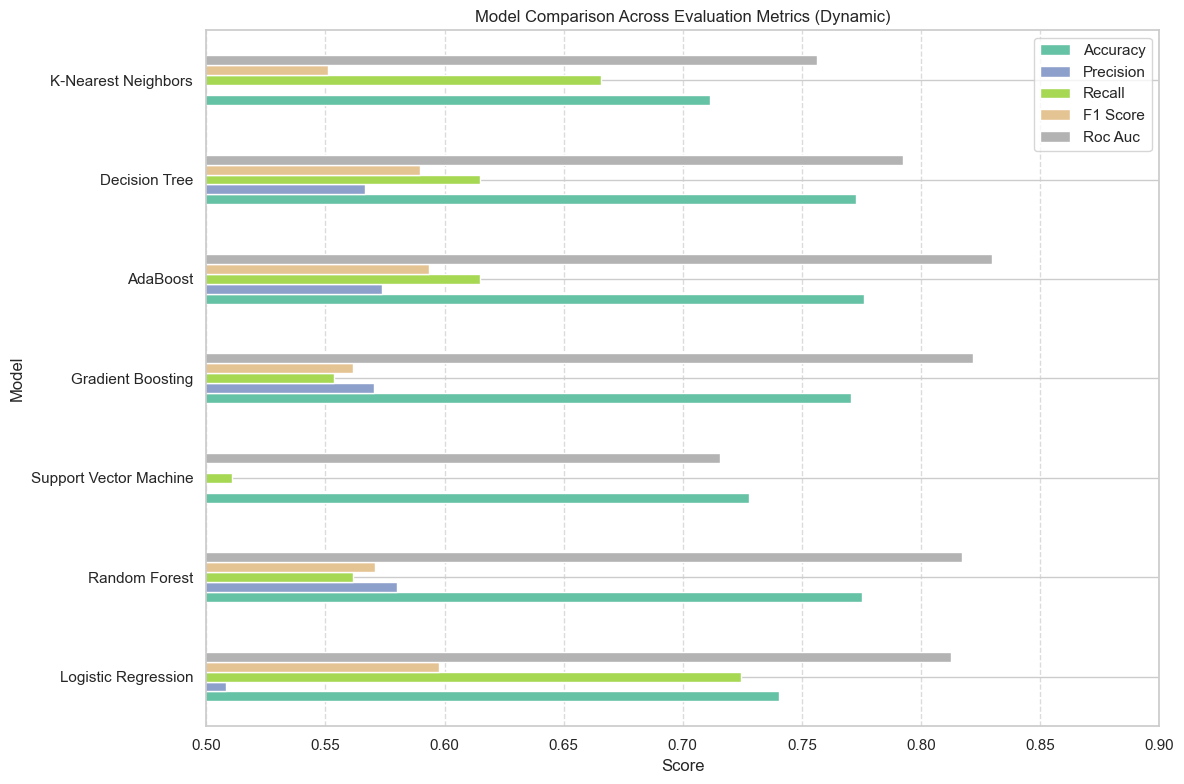

In [19]:
# Turning results dictionary into a dataframe
dynamic_df = pd.DataFrame.from_dict(results, orient="index")

# Customising the column names
dynamic_df.columns = [col.replace("_", " ").title() for col in dynamic_df.columns]
dynamic_df.index.name = "Model"

# Creating the figure
plt.figure(figsize=(12, 6))

# Creating the plot
dynamic_df.plot(kind = "barh", figsize=(12, 8), colormap = "Set2")

# Customising the plot
plt.title("Model Comparison Across Evaluation Metrics (Dynamic)")
plt.xlabel("Score")
plt.xlim(0.5, 0.9)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Showing the plot
plt.show();

#### ROC Curves

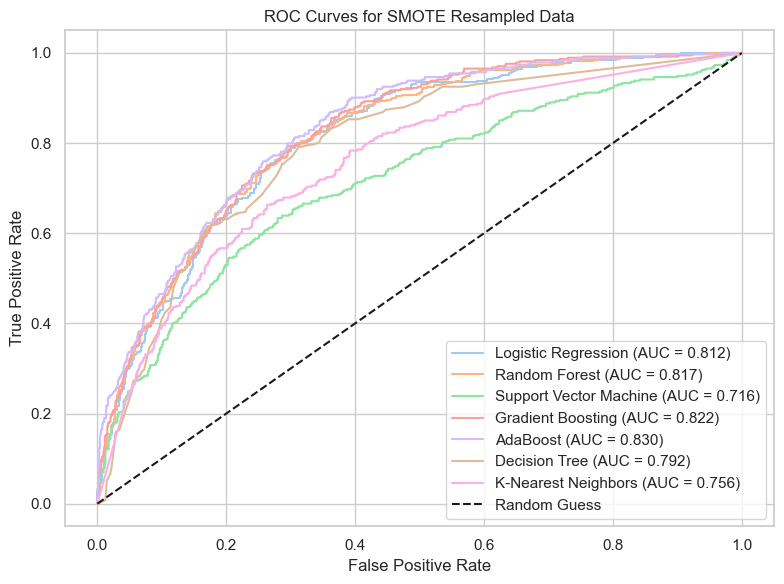

In [20]:
# Plotting ROC Curves
plot_roc_curves(trained_models, title = "ROC Curves for SMOTE Resampled Data")

#### Confusion Matrices

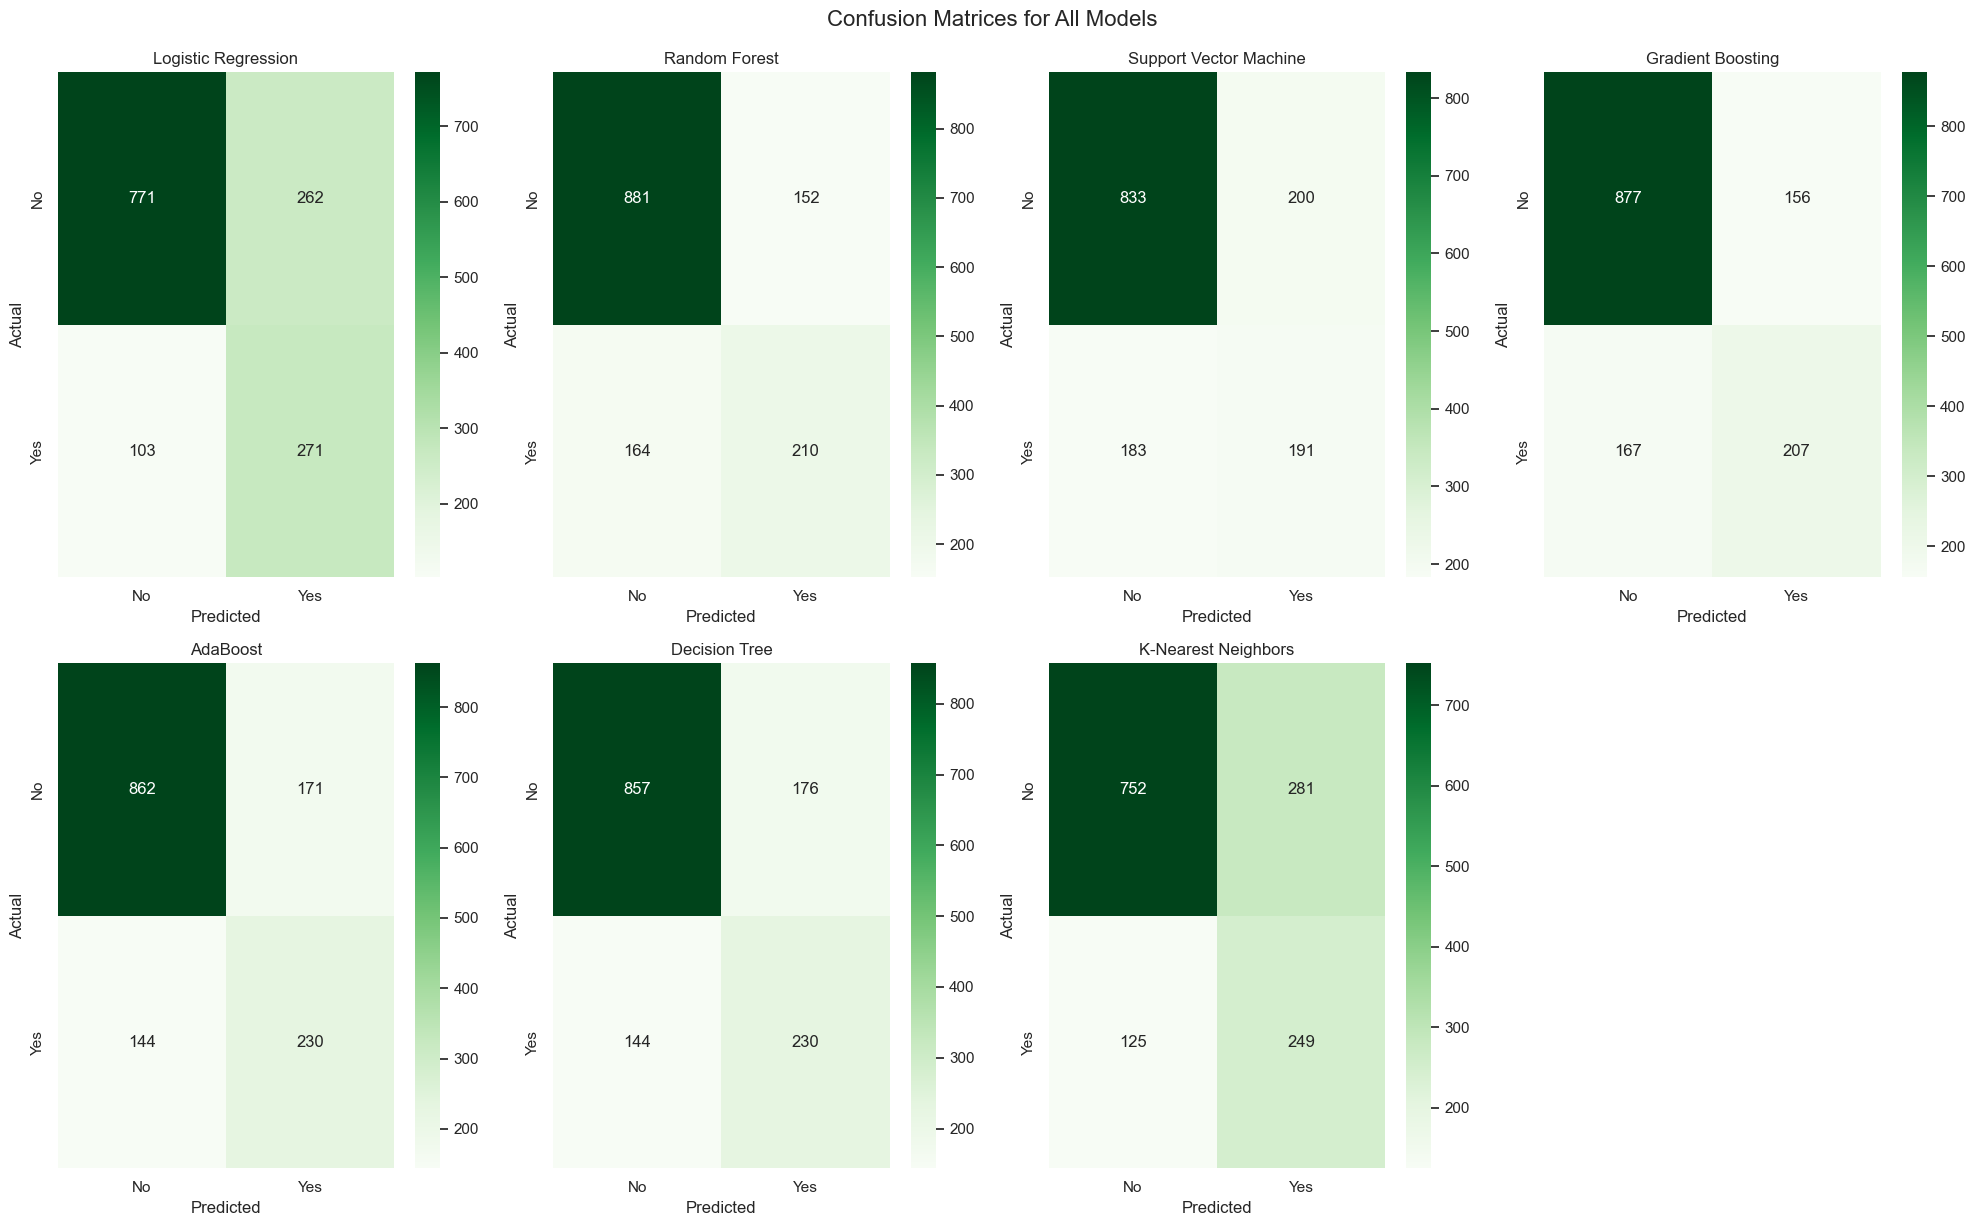

In [22]:
# Setting up the plots
n_models = len(results)
cols = 4
rows = (n_models + cols - 1) // cols
figsize = (20, 12)

# Creating the figure
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

# Creating the plot
for i, (name, r) in enumerate(results.items()):
    cm = r["cm"]
    sns.heatmap(
        cm,
        annot = True,
        fmt = "d",
        cmap = "Greens",
        xticklabels = ["No", "Yes"],
        yticklabels = ["No", "Yes"],
        ax = axes[i],
    )
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", fontsize=16, y=1.02)
plt.show()

In [23]:
# Saving off the files to csv
results_df = pd.DataFrame(results).T

# we don't need confusion matrix in the final results, we already plotted it
results_df.drop("cm", axis=1, inplace=True)
results_df = results_df[["accuracy", "precision", "recall", "f1_score", "roc_auc"]]

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# model_performance.csv is always the latest model performance file
results_df.to_csv(f"{result_path}{result_name}_{timestamp}.{result_ext}", index=True)

In [24]:
results_df

,accuracy,precision,recall,f1_score,roc_auc
Logistic Regression,0.740583,0.508443,0.724599,0.597574,0.812425
Random Forest,0.775409,0.58011,0.561497,0.570652,0.817408
Support Vector Machine,0.72779,0.488491,0.510695,0.499346,0.715516
Gradient Boosting,0.770434,0.570248,0.553476,0.561737,0.821808
AdaBoost,0.776119,0.573566,0.614973,0.593548,0.829871
Decision Tree,0.772566,0.566502,0.614973,0.589744,0.792411
K-Nearest Neighbors,0.711443,0.469811,0.665775,0.550885,0.756348
